In [20]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import unet
import keras.backend as K
from helpers import f1
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [21]:
model = unet(256, 256, 3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 256, 256, 16)         448       ['input_4[0][0]']             
                                                                                                  
 dropout_27 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_57[0][0]']           
                                                                                                  
 conv2d_58 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_27[0][0]']          
                                                                                            

In [22]:
# Images generator (RGB)
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    'data_v3_processed/train/images',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='rgb',
    seed=42)

# Masks generator (grayscale, single channel)
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    'data_v3_processed/train/masks',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

Found 3285 images belonging to 2 classes.
Found 3285 images belonging to 2 classes.


In [33]:
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    'data_v3_processed/val/images',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='rgb',
    seed=42,
    shuffle = False,)

# Masks generator (grayscale, single channel)
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    'data_v3_processed/val/masks',
    target_size=(256, 256),
    batch_size=8,
    class_mode=None,
    color_mode='grayscale',
    seed=42,
    shuffle = False,)

TypeError: ImageDataGenerator.flow_from_directory() got an unexpected keyword argument 'infinite'

In [24]:
def combine_generator(image_generator, mask_generator):
    while True:
        for img_batch, mask_batch in zip(image_generator, mask_generator):
            yield img_batch, mask_batch

train_generator = combine_generator(train_image_generator, train_mask_generator)
val_generator = combine_generator(val_image_generator, val_mask_generator)

In [25]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=1,
                    steps_per_epoch=2000,
                    validation_steps=13)

2000/2000 [==============================] - 276s 137ms/step - loss: 0.0102 - f1: 0.6185 - val_loss: 0.0130 - val_f1: 0.6627


In [27]:
import cv2

img = cv2.imread('data_v3_processed/train/images/images/28_01_08_11.png')
mask = cv2.imread('data_v3_processed/train/masks/masks/28_01_08_11.tif')

img_np = np.array(img)
mask_np = np.array(mask)

print(np.unique(img_np))
print(np.unique(mask_np))

[ 37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255]
[0 1]


In [28]:
img = cv2.imread('data_v3_processed/val/images/images/28_04_02_11.png')
mask = cv2.imread('data_v3_processed/val/masks/masks/28_04_02_11.tif')

img_np = np.array(img)
mask_np = np.array(mask)

print(np.unique(img_np))
print(np.unique(mask_np))

[ 43  44  45  47  48  49  50  51  52  53  54  55  56  58  59  60  61  62
  63  64  65  67  69  70  71  72  74  75  76  77  78  79  80  81  82  83
  85  86  87  88  89  91  92  93  94  96  97  98  99 103 104 105 106 107
 108 109 110 112 113 115 116 117 118 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 192]
[0 1]


In [29]:
import cv2
import numpy as np

img = cv2.imread('data_v3_processed/test/images/images/28_05_08_11.png')
mask = cv2.imread('data_v3_processed/test/masks/masks/28_05_08_11.tif')

img_np = np.array(img)
img_np = np.expand_dims(img_np, axis=0)
img_np = img_np / 255

pred = model.predict(img_np)

1/1 [==============================] - 0s 252ms/step


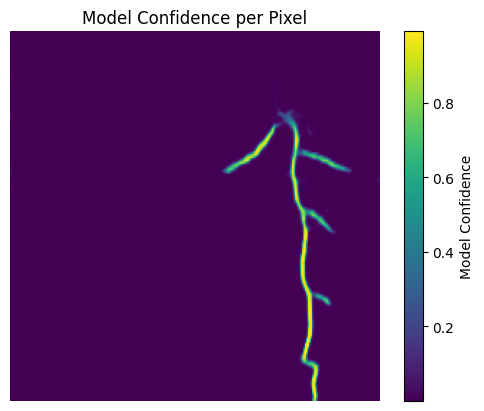

In [30]:
import matplotlib.pyplot as plt

confidence_map = pred[0, :, :, 0]  # Remove batch and channel dims

plt.imshow(confidence_map, cmap='viridis')
plt.colorbar(label="Model Confidence")
plt.title("Model Confidence per Pixel")
plt.axis('off')
plt.show()

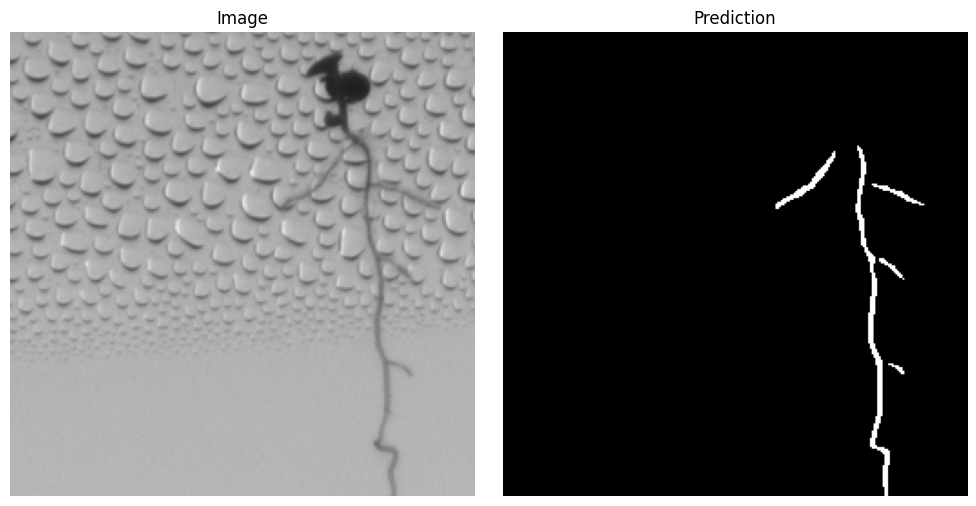

In [31]:
pred = (pred > 0.5).astype(np.uint8)

pred_img = np.squeeze(pred, axis=0)
pred_vis = (pred_img * 255).astype(np.uint8)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # width x height in inches

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_vis, cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
model.save("unet_model.h5")